# Generation of image for SExtractor from simulation

Creates train and test sets from Axel's simulations.

- Train sets should be transformed into images so that they can be processed by SExtractor to produce all the information PSFEx needs.
- Test sets classical .fits catalogs with the minimum information used to interpolate.

Be careful as the correction jupyter notebok has to be used on the test catalogs generated in order to follow the same convention as Sextractor.

### Imports

In [2]:
import numpy as np
import scipy.stats as sst
import matplotlib.pyplot as plt
import progressbar as pb
import os

from astropy.io import fits
from shapepipe.pipeline import file_io

### User parameters

In [3]:
# Location of the file containing raw simulated stars
CCD_number = 38
# simu_path = '/Users/mschmitz/jbonnin/Data/CFIS_PSF'
simu_path = '/Users/tliaudat/Documents/PhD/codes/venv_p3/JB-data/npy-data'

# Directory used to store generated catalogs
# output_path = '/Users/mschmitz/jbonnin/Data/CFIS_PSF/CCD-{}_newsexdataset'.format(CCD_number)
output_path = '/Users/tliaudat/Documents/PhD/codes/venv_p3/JB-data/TL_sexcatalog/CCD-{}_newsexdataset'.format(CCD_number)

# Path of a model file for creating .fits catalogs
# basic_fits = '/Users/mschmitz/jbonnin/Data/all_w3_star_cat/star_selection-2079613-0.fits'
basic_fits = '/Users/tliaudat/Documents/PhD/codes/venv_p3/JB-data/other-JB-data/all_w3_star_cat/star_selection-2079613-0.fits'


### Pre-defined functions

In [4]:
def create_fits(fits_path, data_dict, fits_ex = basic_fits):
    """
    Create a .fits file
    INPUTS:
        fits_path: path to the future .fits file
        data_dict: dictionnary where data is stored (usually {'VIGNET': ..., 'XWIN_IMAGE': ..., ...})
        fits_ex: path to an existing .fits file used as a model
    """
    fits_file = file_io.FITSCatalog(fits_path, open_mode = file_io.BaseCatalog.OpenMode.ReadWrite, SEx_catalog=True)
    fits_file.save_as_fits(data_dict, sex_cat_path = basic_fits)


def create_im_fits(fits_path, im):
    """
    Create a .fits file
    INPUTS:
        fits_path: path to the future .fits file
        data_dict: dictionnary where data is stored (usually {'VIGNET': ..., 'XWIN_IMAGE': ..., ...})
        fits_ex: path to an existing .fits file used as a model
    """
    fits_file = file_io.FITSCatalog(fits_path, open_mode = file_io.BaseCatalog.OpenMode.ReadWrite)
    fits_file.save_as_fits(im, image = True)

### Load the data

In [5]:
simu = np.load('{}/psf_ccd_{}.npy'.format(simu_path, CCD_number), allow_pickle = True).item()
print(simu.keys())

N_stars = len(simu['CCD_n'])
print('{} stars in CCD {}'.format(N_stars, CCD_number))

dict_keys(['vignet', 'e1_true', 'e2_true', 'fwhm', 'CCD_n', 'X', 'Y'])
24823 stars in CCD 38


In [6]:
simu['vignet'].shape

(24823, 51, 51)

In [7]:
# Identifying CCD-pixels

X_px = np.sort(list(set(simu['X'])))
Y_px = np.sort(list(set(simu['Y'])))

x_gap = int(X_px[1] - X_px[0])
print('Width of a CCD_pixel: {}'.format(x_gap))

y_gap = int(Y_px[1] - Y_px[0])
print('Height of a CCD_pixel: {}'.format(y_gap))

Width of a CCD_pixel: 409
Height of a CCD_pixel: 461


In [8]:
# Recovering index of stars present in each CCD-pixel

px_pos = [[[] for y in Y_px] for x in X_px]

for k in range(N_stars):
    for i in range(len(X_px)):
        for j in range(len(Y_px)):
            if (simu['X'][k] == X_px[i]) and (simu['Y'][k] == Y_px[j]):
                px_pos[i][j].append(k)

N_stars_pCCD = np.array([[len(stars) for stars in px_col] for px_col in px_pos])
print(np.array(N_stars_pCCD).T)

min_px = np.min(N_stars_pCCD)
print('Minimum number of stars per CCD-pixel: {}'.format(min_px))

[[470 521 526 470 480]
 [526 489 529 517 480]
 [473 501 458 516 500]
 [505 509 457 521 491]
 [518 502 495 497 496]
 [462 489 484 495 523]
 [453 473 466 505 511]
 [526 517 469 483 528]
 [469 475 490 515 511]
 [542 505 477 514 494]]
Minimum number of stars per CCD-pixel: 453


### Select stars

In [7]:
N_catalogs = min_px // 2

flat_idx = [idx for col in px_pos for idx in col]
slices_idx = [list(s) for s in zip(*flat_idx)]

test_slices_idx = slices_idx[:N_catalogs]
train_slices_idx = slices_idx[N_catalogs:-1]

train_idx = np.array(train_slices_idx).flatten()

### Build test catalogs

In [8]:
test_dicts = [{'VIGNET': simu['vignet'][s], 'XWIN_IMAGE': simu['X'][s], 'YWIN_IMAGE': simu['Y'][s], 'NUMBER': np.arange(1, len(s)+1)} for s in slices_idx[:N_catalogs]]

if os.path.isdir(output_path):
    os.system('rm ' + output_path + '/test-star_selection*')
else:
    os.system('mkdir ' + output_path)
print('Building test stars catalogs ...')
for n in pb.progressbar(range(N_catalogs)):
    create_fits('{}/test-star_selection-{:07d}-{}.fits'.format(output_path, n, CCD_number), test_dicts[n])
print('Done')

  3% (9 of 226) |                        | Elapsed Time: 0:00:00 ETA:   0:00:04

Building test stars catalogs ...


100% (226 of 226) |######################| Elapsed Time: 0:00:04 Time:  0:00:04


Done


### Select train stars

In [9]:
np.random.seed(0)
rand_train_idx = np.copy(train_idx)
np.random.shuffle(rand_train_idx)
train_selections = [rand_train_idx[(50 * n):(50 * (n + 1))] for n in range(N_catalogs)]

### Create big pictures for training stars

In [35]:
CCD_w = 2048
CCD_h = 4612
half_size = 25
edge_mask = 50
sig_noise = 1e-3

np.random.seed(0)

for n in pb.progressbar(range(N_catalogs)):
    # Create big pictures
    Im_vig = np.zeros((CCD_w,CCD_h))
    Im_pos = np.zeros((CCD_w,CCD_h))
    
    # Add noise
    noise = sst.norm.rvs(scale = sig_noise, size = CCD_w * CCD_h)
    Im_vig += noise.reshape((CCD_w,CCD_h))
    
    # Shift train stars
    s_idx = train_selections[n]
    x_shifts = sst.uniform.rvs(loc = - x_gap / 2, scale = x_gap, size = 50)
    y_shifts = sst.uniform.rvs(loc = - y_gap / 2, scale = y_gap, size = 50)

    x = np.floor(simu['X'][train_selections[n]] + x_shifts)
    y = np.floor(simu['Y'][train_selections[n]] + y_shifts)
    
    # Make sure that no stars is in the border and add them to the image
    for k in range(50):
        while (x[k] < edge_mask) or (x[k] >= CCD_w - edge_mask) or (y[k] < edge_mask) or (y[k] >= CCD_h - edge_mask):
            new_x_shift = sst.uniform.rvs(loc = - x_gap / 2, scale = x_gap)
            new_y_shift = sst.uniform.rvs(loc = - y_gap / 2, scale = y_gap)
            x[k] = int((simu['X'][train_selections[n][k]] + new_x_shift))
            y[k] = int((simu['Y'][train_selections[n][k]] + new_y_shift))

        Im_vig[int(x[k]-half_size):int(x[k]+half_size+1),int(y[k]-half_size):int(y[k]+half_size+1)] += simu['vignet'][train_selections[n][k]]
        Im_pos[int(x[k]),int(y[k])] = 1
    
    create_im_fits('{}/train-star-im_selection-{:07d}-{}.fits'.format(output_path, n, CCD_number), Im_vig.T)
    create_im_fits('{}/train-star-pos_selection-{:07d}-{}.fits'.format(output_path, n, CCD_number), Im_pos.T)
    

100% (226 of 226) |######################| Elapsed Time: 0:18:06 Time:  0:18:06


## *Test image orientation*

In [40]:
image = np.zeros((21,21))
idx = ([0,1,2,19,20,1,19,20],[0,1,2,19,20,19,0,1])
image[idx] = 1

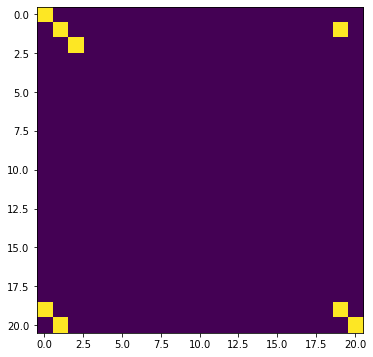

In [45]:
plt.figure(figsize = (6,6))
plt.imshow(image)
plt.show()

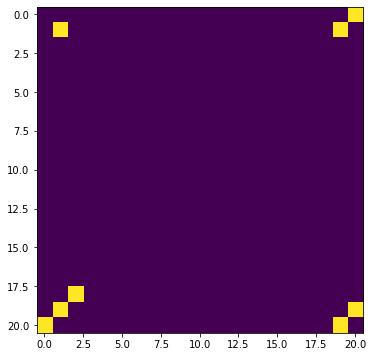

In [46]:
plt.figure(figsize = (6,6))
plt.imshow(image.T[::-1,])
plt.show()

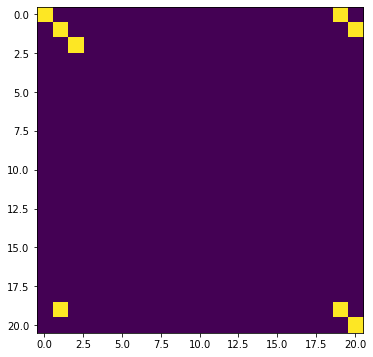

In [47]:
plt.figure(figsize = (6,6))
plt.imshow(image.T)
plt.show()

In [24]:
create_im_fits('/Users/mschmitz/jbonnin/test0.fits', image)
create_im_fits('/Users/mschmitz/jbonnin/test1.fits', image.T[::-1,])
create_im_fits('/Users/mschmitz/jbonnin/test2.fits', image.T) # ---> the right way

## *Real cat to reconstructed cat*

In [105]:
realcat_path = '/Users/mschmitz/jbonnin/Data/CFIS_PSF/Tests/realcat.fits'
recim_path = '/Users/mschmitz/jbonnin/Data/CFIS_PSF/Tests/recim.fits'
starcat = fits.open(realcat_path)

stars = starcat[2].data['VIGNET']
X = starcat[2].data['XWIN_IMAGE']
Y = starcat[2].data['YWIN_IMAGE']

Xint = np.array(X, dtype = 'int')
Yint = np.array(Y, dtype = 'int')

N_stars = stars.shape[0]

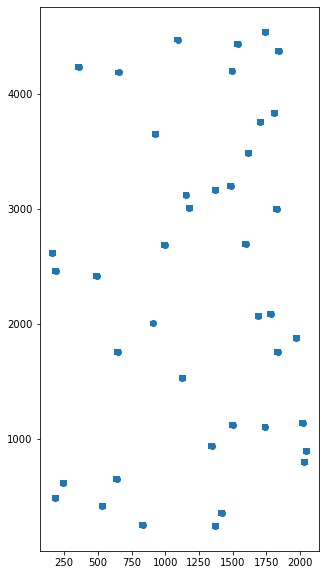

In [106]:
from matplotlib.patches import Rectangle
hsize = 25
ccd_w = 2112 # 2048
ccd_h = 4644 # 4612

plt.figure(figsize = (5, 10))
ax = plt.gca()
ax.scatter(X, Y)
for k in range(N_stars):
    ax.add_artist(Rectangle((Xint[k]-hsize,Yint[k]-hsize), 2*hsize+1, 2*hsize+1))
plt.show()

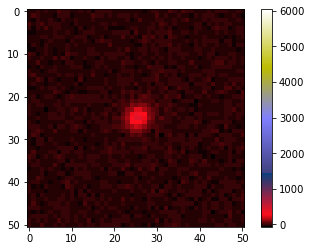

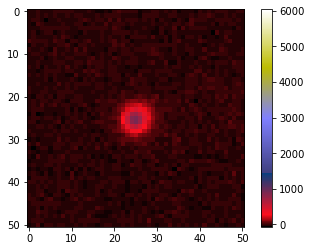

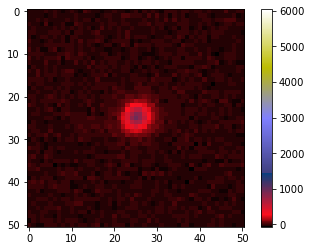

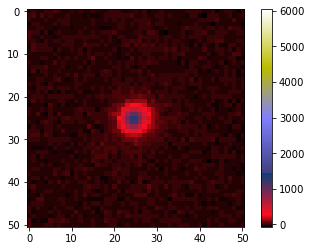

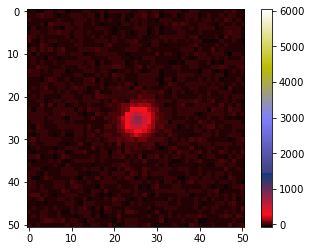

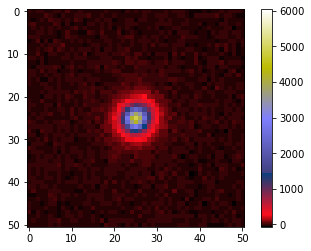

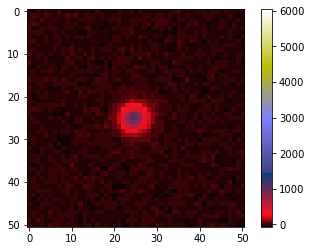

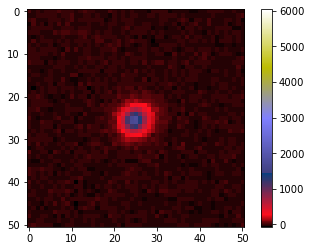

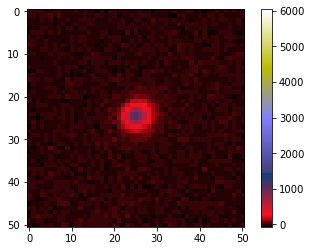

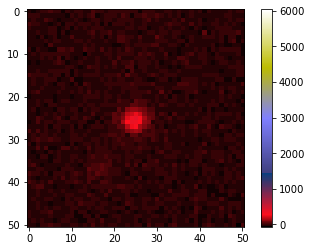

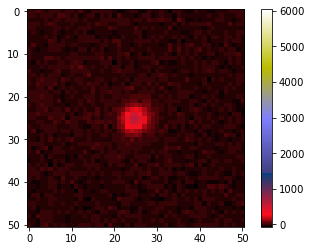

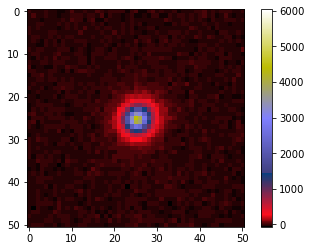

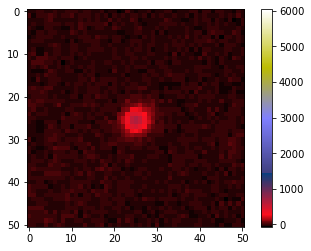

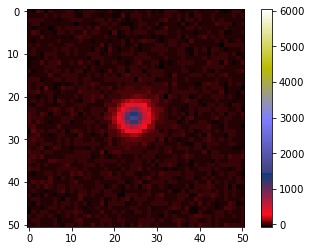

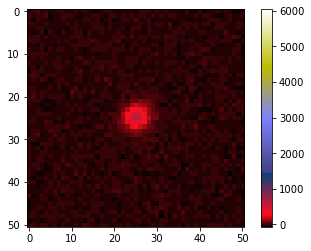

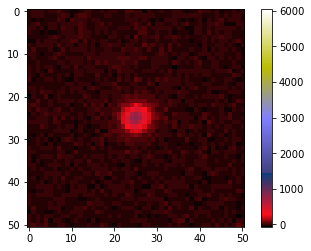

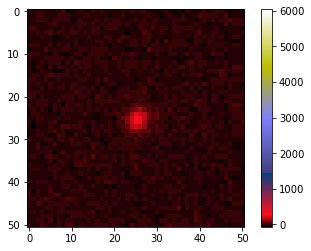

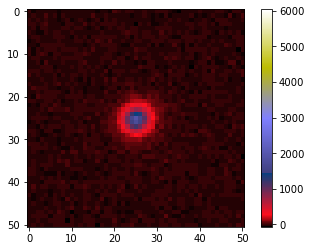

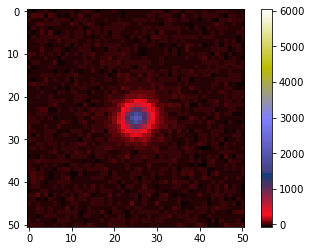

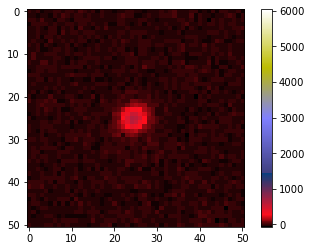

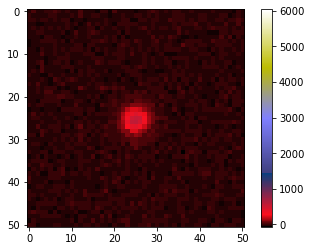

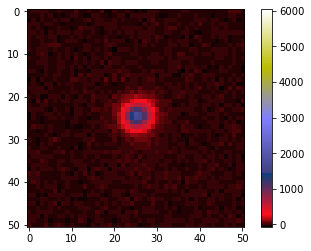

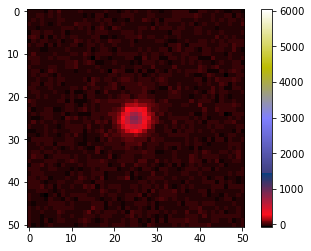

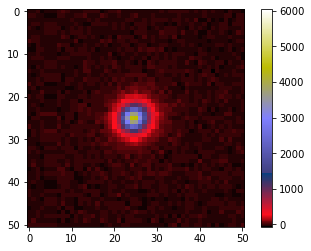

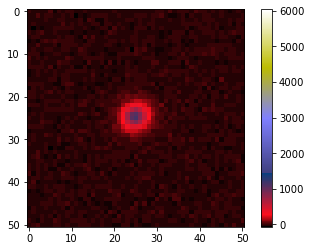

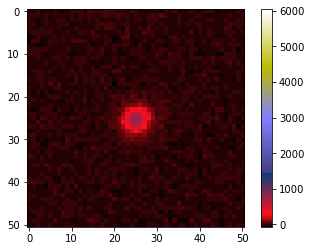

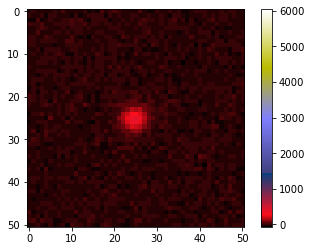

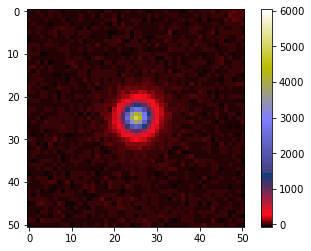

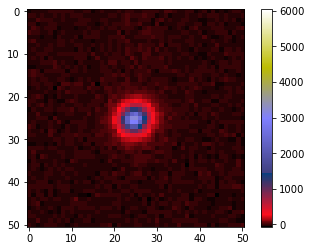

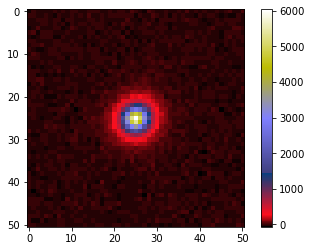

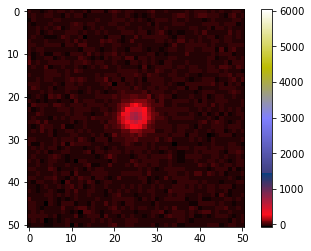

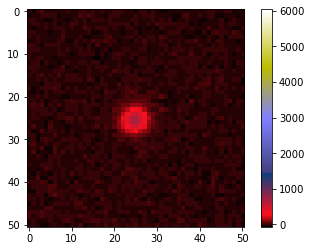

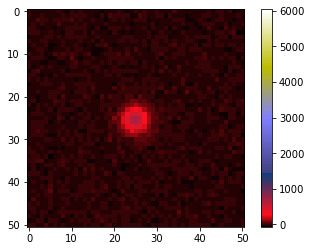

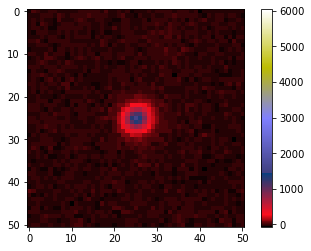

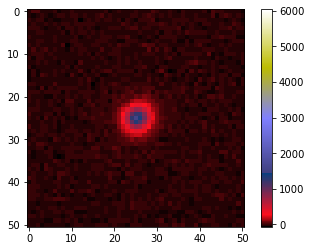

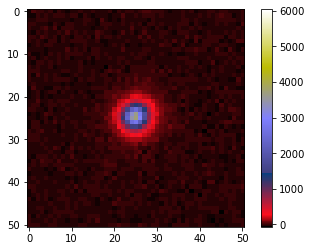

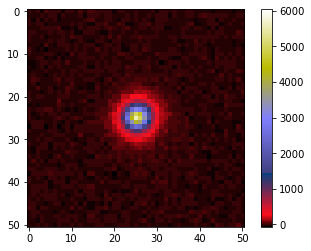

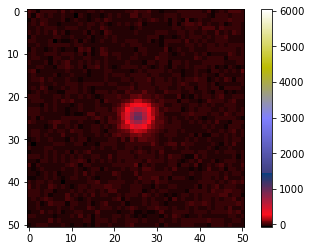

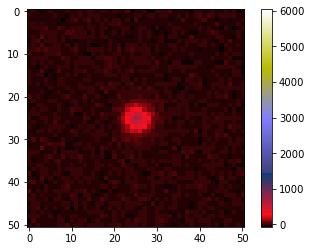

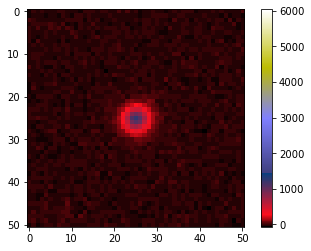

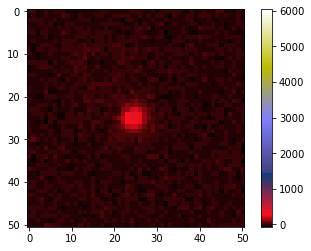

In [107]:
stars[stars < -1e10] = np.random.normal(scale = 14.5, size = len(np.where(stars < -1e10)[0]))
max_px = np.max(stars)
min_px = np.min(stars)

for star in stars:
    plt.imshow(star, cmap = 'gist_stern', vmin = min_px, vmax = max_px)
    plt.colorbar()
    plt.show()

In [108]:
# image = np.zeros((2112,4644))

image = np.random.normal(scale = 14.5, size = ccd_w*ccd_h).reshape((ccd_w,ccd_h))

for k in range(N_stars):
    image[Xint[k]-hsize:Xint[k]+hsize+1,Yint[k]-hsize:Yint[k]+hsize+1] = stars[k]

In [110]:
create_im_fits(recim_path, image.T)

In [111]:
N_stars

41